# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

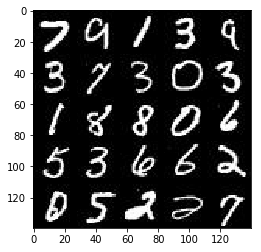

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

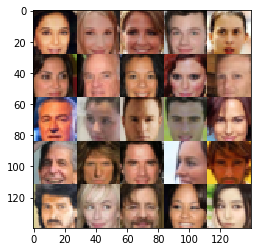

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real,  inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = tf.layers.conv2d(images, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu0 = tf.maximum(alpha * conv0, conv0)
        
        conv1 = tf.layers.conv2d(conv0, 256, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor1 = tf.layers.batch_normalization(conv1, training=True)
        drop1 = tf.layers.dropout(bnor1, 0.5)
        maxi1 = tf.maximum(alpha * drop1, drop1)

        conv2 = tf.layers.conv2d(maxi1, 512, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor2 = tf.layers.batch_normalization(conv2, training=True)
        drop2 = tf.layers.dropout(bnor2, 0.5)
        maxi2 = tf.maximum(alpha * drop2, drop2)

        conv3 = tf.layers.conv2d(maxi2, 1024, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor3 = tf.layers.batch_normalization(conv3, training=True)
        drop3 = tf.layers.dropout(bnor3, 0.5)
        maxi3 = tf.maximum(alpha * drop3, drop3)

        flat = tf.reshape(maxi3, (-1, 2*2*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):

        dens1 = tf.layers.dense(z, 2*2*1024)

        resh1 = tf.reshape(dens1, (-1, 2, 2, 1024))
        bnor1 = tf.layers.batch_normalization(resh1, training=is_train)
        drop1 = tf.layers.dropout(bnor1, 0.5)
        maxi1 = tf.maximum(alpha * drop1, drop1)

        conv2 = tf.layers.conv2d_transpose(maxi1, 512, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor2 = tf.layers.batch_normalization(conv2, training=is_train)
        drop2 = tf.layers.dropout(bnor2, 0.5)
        maxi2 = tf.maximum(alpha * drop2, drop2)

        conv3 = tf.layers.conv2d_transpose(maxi2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor3 = tf.layers.batch_normalization(conv3, training=is_train)
        drop3 = tf.layers.dropout(bnor3, 0.5)
        maxi3 = tf.maximum(alpha * drop3, drop3)

        conv4 = tf.layers.conv2d_transpose(maxi3, 128, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bnor4 = tf.layers.batch_normalization(conv4, training=is_train)
        drop4 = tf.layers.dropout(bnor4, 0.5)
        maxi4 = tf.maximum(alpha * drop4, drop4)

        logits = tf.layers.conv2d_transpose(maxi4, out_channel_dim, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 
    print_every = 20
    show_every = 100
    
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1

                # Sample random noise for the Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                #Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})
                losses.append((train_loss_d, train_loss_g))
                
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                                     
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

    np_losses = np.array(losses)
    pyplot.plot(np_losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(np_losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    print("Done!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 8.6205
Epoch 1/2... Discriminator Loss: 2.3073... Generator Loss: 8.0597
Epoch 1/2... Discriminator Loss: 3.7846... Generator Loss: 3.2509
Epoch 1/2... Discriminator Loss: 2.1260... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 2.0622... Generator Loss: 5.3432


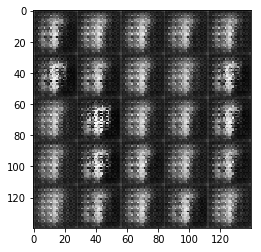

Epoch 1/2... Discriminator Loss: 0.2921... Generator Loss: 1.8851
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 2.9331
Epoch 1/2... Discriminator Loss: 1.8837... Generator Loss: 3.1863
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.6282


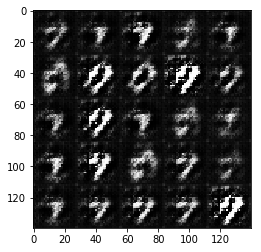

Epoch 1/2... Discriminator Loss: 1.6315... Generator Loss: 1.9805
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 2.8703
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 2.4652
Epoch 1/2... Discriminator Loss: 1.9479... Generator Loss: 2.7969


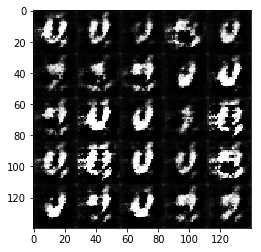

Epoch 1/2... Discriminator Loss: 1.7281... Generator Loss: 0.2644
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.3727
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.4034
Epoch 1/2... Discriminator Loss: 2.3995... Generator Loss: 0.1510
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 1.2434


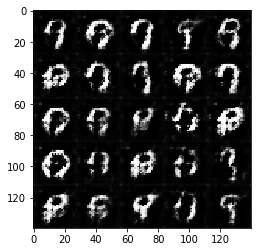

Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 0.3119
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.2864


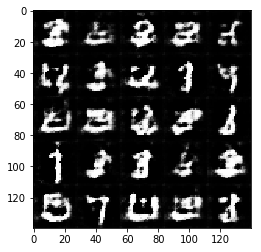

Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 1.7724
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.0813


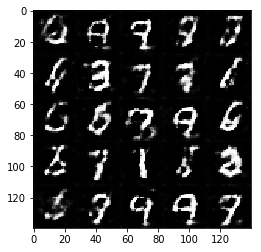

Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 1.4311
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.6828


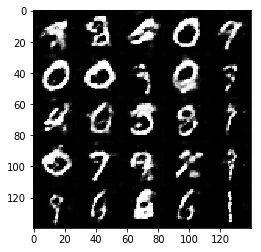

Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.3496
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 1.8474
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.5048
Epoch 1/2... Discriminator Loss: 1.6084... Generator Loss: 0.3563


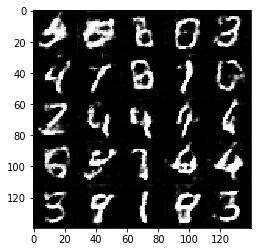

Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 1.5711
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.0482
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 1.3924


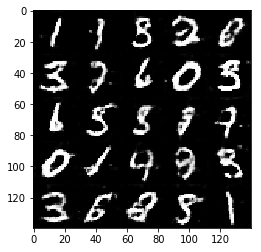

Epoch 1/2... Discriminator Loss: 1.8791... Generator Loss: 1.9535
Epoch 2/2... Discriminator Loss: 1.8131... Generator Loss: 0.2071
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.3331
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 1.7894


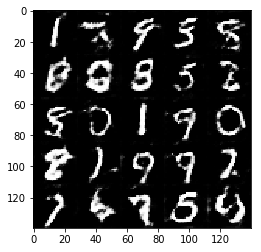

Epoch 2/2... Discriminator Loss: 1.6033... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 1.5503... Generator Loss: 0.3473
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 1.7327... Generator Loss: 0.2448


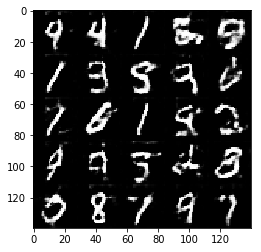

Epoch 2/2... Discriminator Loss: 1.6734... Generator Loss: 0.2815
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.5568
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 1.8377... Generator Loss: 0.2290


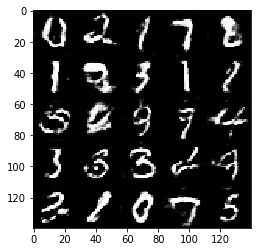

Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.4930
Epoch 2/2... Discriminator Loss: 1.6643... Generator Loss: 0.2532
Epoch 2/2... Discriminator Loss: 1.7192... Generator Loss: 0.2595
Epoch 2/2... Discriminator Loss: 1.5899... Generator Loss: 0.2994
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.3620


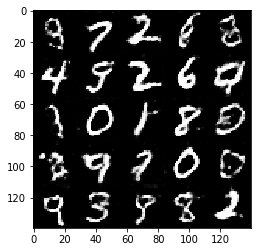

Epoch 2/2... Discriminator Loss: 1.6342... Generator Loss: 0.2832
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 1.2327
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 2.0119
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.4968


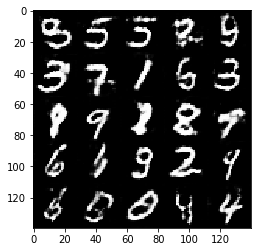

Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.6909... Generator Loss: 0.2621
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 1.9646
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 0.6526


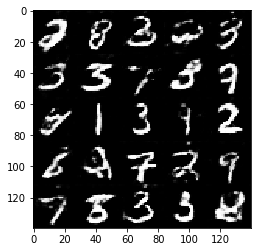

Epoch 2/2... Discriminator Loss: 1.6310... Generator Loss: 0.3262
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 1.5097
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 1.5683


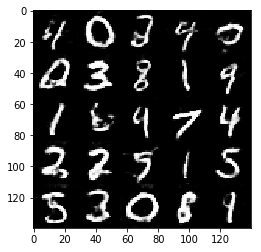

Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.5939... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 1.5839... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 1.0192... Generator Loss: 1.3762


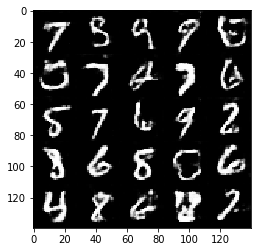

Epoch 2/2... Discriminator Loss: 1.7570... Generator Loss: 0.2348
Epoch 2/2... Discriminator Loss: 1.4825... Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.3944
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.4218


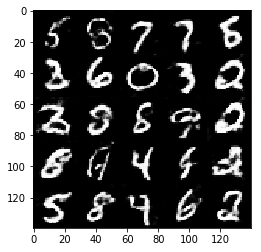

Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.6663... Generator Loss: 0.2561


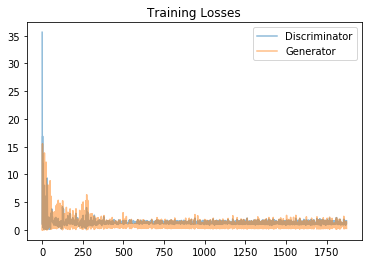

Done!


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1425... Generator Loss: 0.1833
Epoch 1/1... Discriminator Loss: 3.4594... Generator Loss: 0.0610
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6344


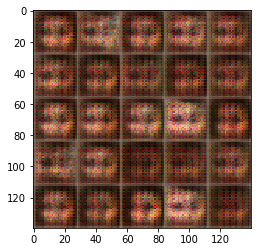

Epoch 1/1... Discriminator Loss: 2.2327... Generator Loss: 0.1774
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.4106


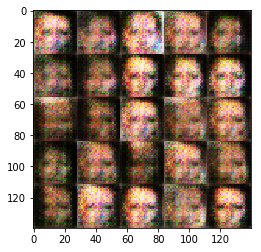

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.9167... Generator Loss: 0.2724
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.3074
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7851


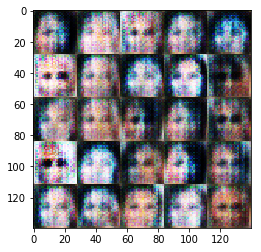

Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 1.0177


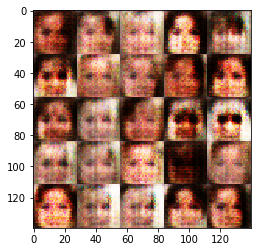

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.4324


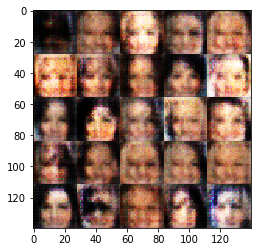

Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 0.2193


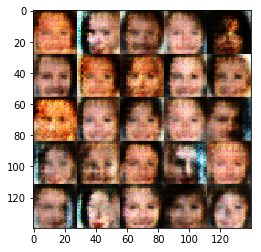

Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.6315


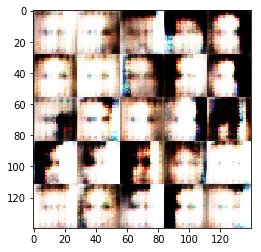

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.2867


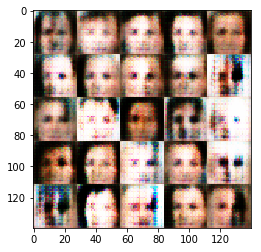

Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.9789


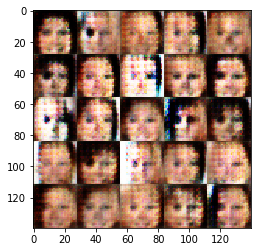

Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 2.0750
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 2.9166


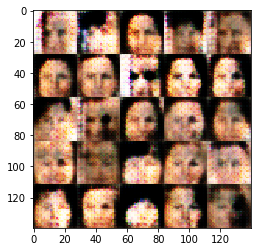

Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.3002
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.7803


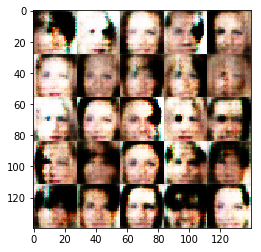

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 2.5038
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 1.9465


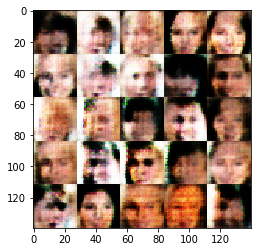

Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 2.3859


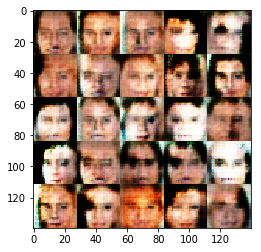

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 2.7771
Epoch 1/1... Discriminator Loss: 1.7292... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 3.2623


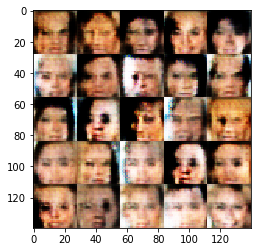

Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.6631... Generator Loss: 4.6026
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 2.0949
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 3.5126


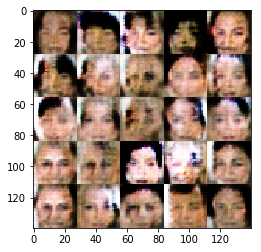

Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 2.2553


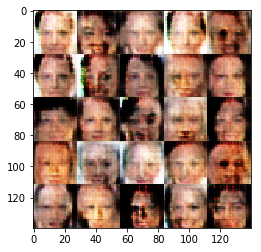

Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.7515... Generator Loss: 3.7477
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 3.8598
Epoch 1/1... Discriminator Loss: 1.7383... Generator Loss: 4.0429


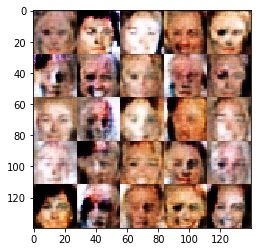

Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 3.4370
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 4.0074
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 3.1375
Epoch 1/1... Discriminator Loss: 0.3166... Generator Loss: 1.7624
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.0186


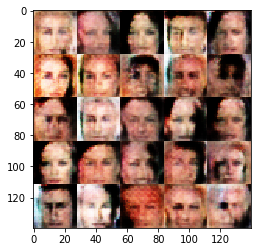

Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 3.1829
Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 3.5227
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 3.6780
Epoch 1/1... Discriminator Loss: 3.0973... Generator Loss: 5.0952


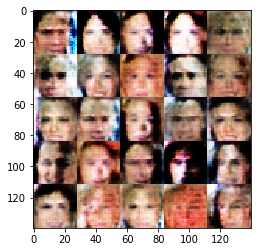

Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 3.7392
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 1.8827
Epoch 1/1... Discriminator Loss: 0.1658... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 2.4184
Epoch 1/1... Discriminator Loss: 0.2092... Generator Loss: 2.0971


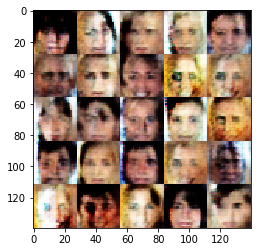

Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 3.1182
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 1.8344
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 4.6078
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 3.8249


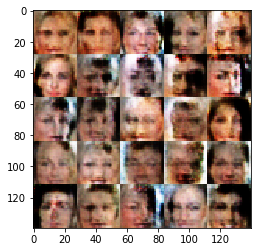

Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 0.8696


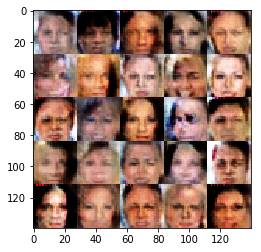

Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.4653
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 3.4005
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 3.6060
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 3.3223


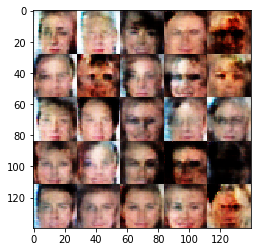

Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 3.1263
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.8037
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 4.1424


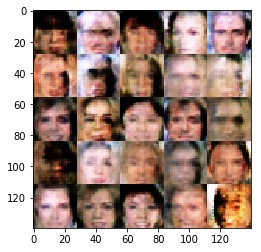

Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.2575
Epoch 1/1... Discriminator Loss: 0.1606... Generator Loss: 2.8009
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 4.5897
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 3.9523
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.5714


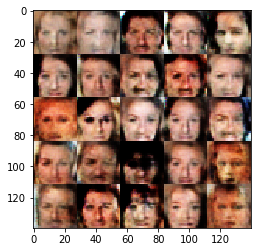

Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.1389... Generator Loss: 2.7364
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 3.9300


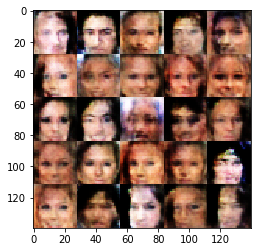

Epoch 1/1... Discriminator Loss: 0.1170... Generator Loss: 2.7780
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 3.1889
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 2.2203


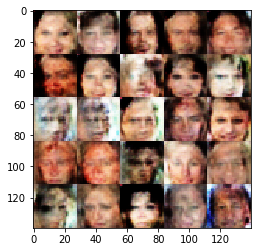

Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 2.6897
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 0.1301... Generator Loss: 4.0464
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 3.9867
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 5.0551


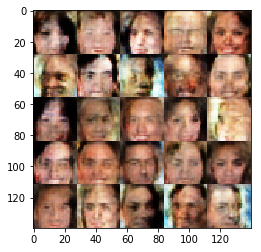

Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 6.9049
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 5.0270
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 0.1530... Generator Loss: 2.8025


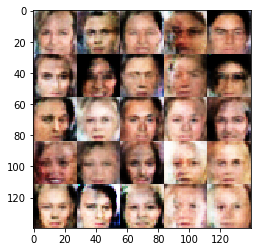

Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 3.1965... Generator Loss: 0.0650
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 2.2469
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 5.4470


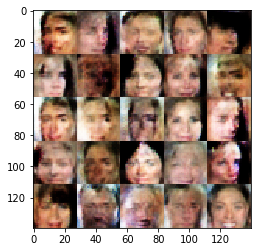

Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 4.5712
Epoch 1/1... Discriminator Loss: 0.2732... Generator Loss: 1.7289
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.3733
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.3106... Generator Loss: 1.6270


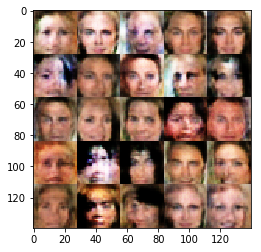

Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 4.4550
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 2.3332
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 3.7098
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 5.2721
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.5229


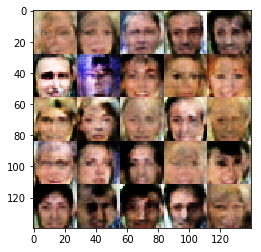

Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 2.9787
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 4.1779
Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 5.5120
Epoch 1/1... Discriminator Loss: 0.3053... Generator Loss: 3.1872
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.2020


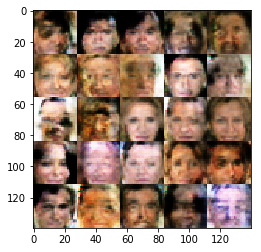

Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 2.5822
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 5.1920
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 4.2718
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 1.5119


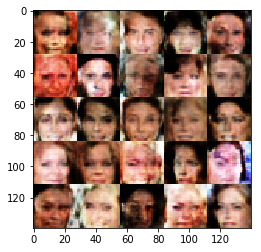

Epoch 1/1... Discriminator Loss: 0.3095... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 2.5663
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 3.7421
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 4.8108


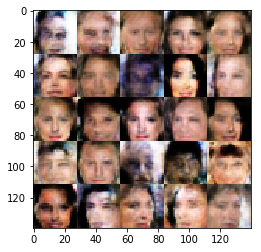

Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 3.7123
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 3.3784


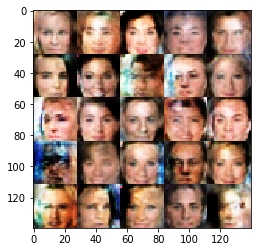

Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 4.9674
Epoch 1/1... Discriminator Loss: 0.2204... Generator Loss: 5.5018
Epoch 1/1... Discriminator Loss: 0.3107... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 2.5256
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.1286


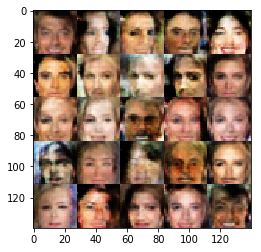

Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 4.8977
Epoch 1/1... Discriminator Loss: 1.7532... Generator Loss: 4.7080
Epoch 1/1... Discriminator Loss: 0.3183... Generator Loss: 1.9893
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.2140


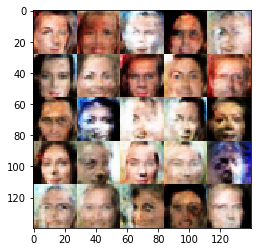

Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 6.4139
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 4.4214
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 5.8610
Epoch 1/1... Discriminator Loss: 0.2163... Generator Loss: 2.3769


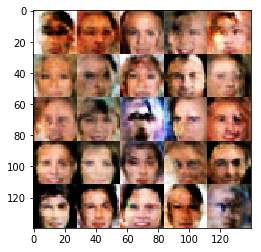

Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 2.0193
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 4.1070
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.9989
Epoch 1/1... Discriminator Loss: 0.2504... Generator Loss: 2.0422
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.2948


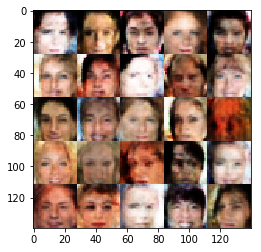

Epoch 1/1... Discriminator Loss: 0.0502... Generator Loss: 5.5021
Epoch 1/1... Discriminator Loss: 0.2547... Generator Loss: 3.9830
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 5.6290
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 3.3870
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.3278


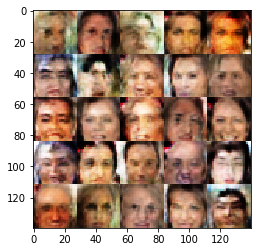

Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 2.7606
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 3.4659
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 0.9258


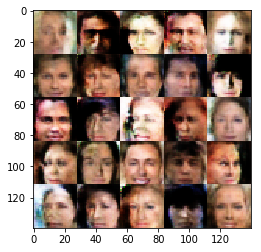

Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 5.9839
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 3.1481
Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 3.0899
Epoch 1/1... Discriminator Loss: 0.2410... Generator Loss: 2.4299


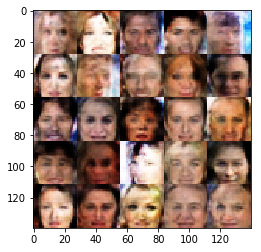

Epoch 1/1... Discriminator Loss: 4.9106... Generator Loss: 9.2507
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 2.7651
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 5.2158
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 1.4612


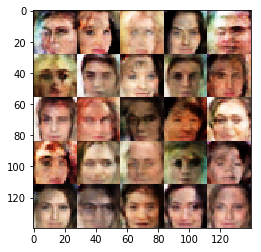

Epoch 1/1... Discriminator Loss: 4.1124... Generator Loss: 0.0248
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 0.2802... Generator Loss: 4.0688
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.3693


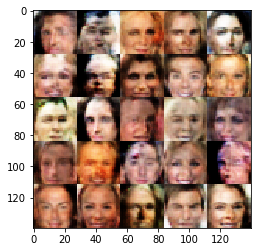

Epoch 1/1... Discriminator Loss: 0.1511... Generator Loss: 2.5152
Epoch 1/1... Discriminator Loss: 0.2773... Generator Loss: 2.3714
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 0.1131... Generator Loss: 2.6305
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 1.7746


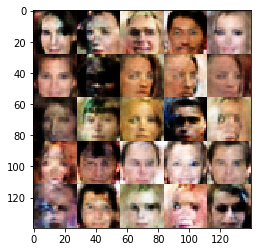

Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 3.8697... Generator Loss: 8.5457
Epoch 1/1... Discriminator Loss: 0.1591... Generator Loss: 3.8268
Epoch 1/1... Discriminator Loss: 4.4720... Generator Loss: 8.8812


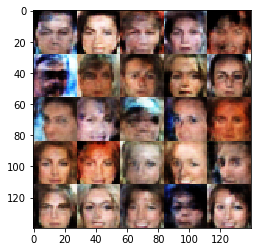

Epoch 1/1... Discriminator Loss: 0.2099... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 2.2925
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 3.7069
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 2.4232
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 2.5979


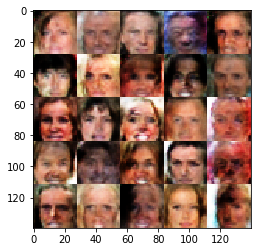

Epoch 1/1... Discriminator Loss: 0.2567... Generator Loss: 4.7041
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.2408... Generator Loss: 2.1430
Epoch 1/1... Discriminator Loss: 3.3845... Generator Loss: 8.1167
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 4.7047


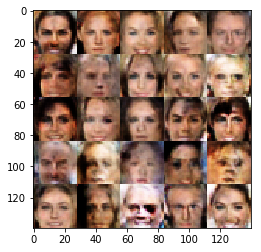

Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 5.8272
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.3300
Epoch 1/1... Discriminator Loss: 0.1093... Generator Loss: 2.9907
Epoch 1/1... Discriminator Loss: 0.1471... Generator Loss: 2.4277
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 3.8162


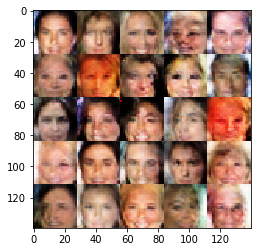

Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 3.8758
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 2.8573
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.8029... Generator Loss: 0.8231


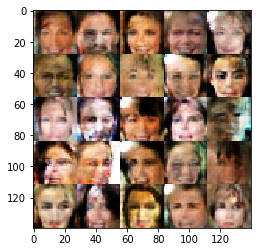

Epoch 1/1... Discriminator Loss: 0.2809... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.1009... Generator Loss: 3.2934
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 4.4511


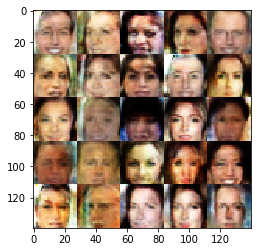

Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 4.8033
Epoch 1/1... Discriminator Loss: 0.2842... Generator Loss: 2.0731
Epoch 1/1... Discriminator Loss: 1.7834... Generator Loss: 6.5360
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 2.2114


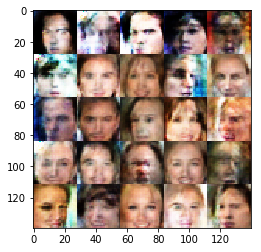

Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.9848
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 5.7511
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 8.5694
Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 2.5286
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.0450


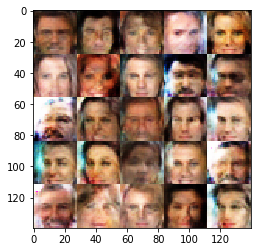

Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.8947
Epoch 1/1... Discriminator Loss: 0.2482... Generator Loss: 2.4725
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 2.7738
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 2.3003


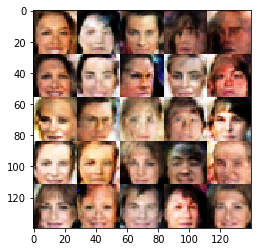

Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 2.0385... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.3862
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 2.6698


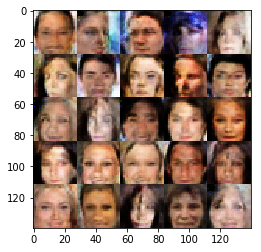

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 4.6291


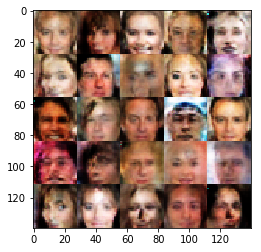

Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 7.5513
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 1.9039
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 0.2624... Generator Loss: 2.2417
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.0726


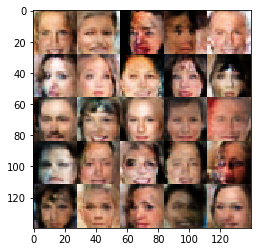

Epoch 1/1... Discriminator Loss: 2.8798... Generator Loss: 7.3113
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 3.0586
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 2.7017


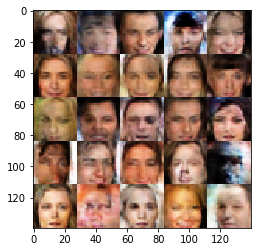

Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 3.0987
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.0098
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 0.2365... Generator Loss: 3.1205


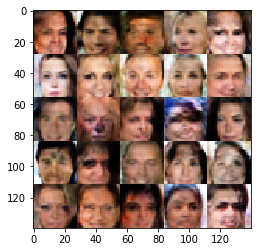

Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 4.3848
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 3.8737


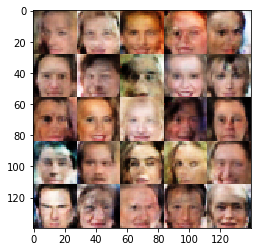

Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 4.6886
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 2.8527
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 4.9944
Epoch 1/1... Discriminator Loss: 0.3166... Generator Loss: 4.6183


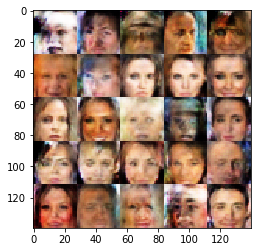

Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 4.6703
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 1.5066
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 5.0748


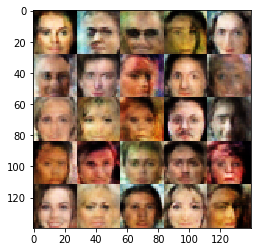

Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 2.6723


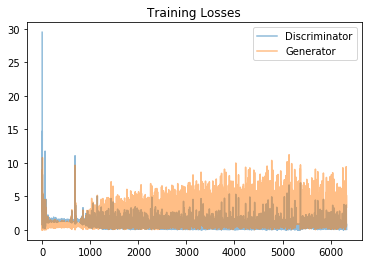

Done!


In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.